# OWA Anholt Array Efficiency: Benchmark Evaluation Script

## Introduction
This is the model evaluation script for the [OWA-Anholt Array Efficiency benchmark](https://thewindvaneblog.com/the-owa-anholt-array-efficiency-benchmark-436fc538597d) as part of the [OWA Wake Modeling Challenge](https://www.carbontrust.com/media/677495/owa-wake-modelling-challenge_final-feb27.pdf).

## Load libraries

In [373]:
%matplotlib inline
import sys
sys.path.append('../')
import warnings

from src.WindConditions import *
from src.BinAvrg import *  
from scipy import interpolate
from IPython.display import Markdown, display

%load_ext autoreload
%autoreload 2

#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors) # set default color cycle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [374]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Participants

In [375]:
n_sim = 19 # number of submited simulations + 1 (ensemble)
sims = pd.DataFrame(columns = ['ID','Ensemble','Participant','Model Name', 'Model Type','Approach','Input','Remarks','Label'],
                   index = np.arange(0,n_sim,1))
sims.loc[0]  = ['anh00a'  ,0,'CENER'    ,'FLORIS'     ,'Porté-Agel'         ,'ba','ctrl,ref','Neutral'         ,'CENER_PortéAgelNeutral_ba_ref']
sims.loc[1]  = ['anh00b'  ,0,'CENER'    ,'FLORIS'     ,'Jensen'             ,'ba','ctrl,ref','Neutral'         ,'CENER_JensenNeutral_ba_ref'   ]
sims.loc[2]  = ['anh00c'  ,0,'CENER'    ,'FLORIS'     ,'Multizone'          ,'ba','ctrl,ref','Neutral'         ,'CENER_MultizoneNeutral_ba_ref']
sims.loc[3]  = ['anh01'   ,0,'ProPlanEn','WakeBlaster','RANS Eddy-Vis'      ,'ts','ctrl,wt' ,' '               ,'ProPlanEn_WakeBlaster_ts_wt']
sims.loc[4]  = ['anh02a'  ,1,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','ctrl,wt' ,'Dynamic Cw'      ,'TUD_PARK83_ts_wt']
sims.loc[5]  = ['anh02b'  ,1,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','ctrl,wt' ,'Dynamic Cw'      ,'TUD_BasPortéAgel_ts_wt']
sims.loc[6]  = ['anh05a'  ,0,'EMD'      ,'WindPro'    ,'PARK2'              ,'ts','ctrl,wt' ,'TI-based lim002' ,'EMD_PARK2ti002_ts_wt']
sims.loc[7]  = ['anh05b'  ,0,'EMD'      ,'WindPro'    ,'PARK2'              ,'ts','ctrl,wt' ,'TI-based lim003' ,'EMD_PARK2ti003_ts_wt']
sims.loc[8]  = ['anh05c'  ,0,'EMD'      ,'WindPro'    ,'PARK2'              ,'ts','ctrl,wt' ,'stab slope1lim01','EMD_PARK2sl1lim01_ts_wt']
sims.loc[9]  = ['anh05d'  ,0,'EMD'      ,'WindPro'    ,'PARK2'              ,'ts','ctrl,wt' ,'stab slope1lim02','EMD_PARK2sl1lim02_ts_wt']
sims.loc[10] = ['anh05e'  ,0,'EMD'      ,'WindPro'    ,'PARK2'              ,'ts','ctrl,wt' ,'stab slope2lim02','EMD_PARK2sl2lim02_ts_wt']
sims.loc[11] = ['anh07a'  ,1,'IFPEN'    ,'FarmShadow' ,'Ishihara&Qian'      ,'ba','ctrl,ref',' '               ,'IFPEN_IsiQian_ba_ref']
sims.loc[12] = ['anh07b'  ,1,'IFPEN'    ,'FarmShadow' ,'Ishihara&Qian'      ,'ts','ctrl,ref',' '               ,'IFPEN_IsiQian_ts_ref']
sims.loc[13] = ['anh07c'  ,1,'IFPEN'    ,'FarmShadow' ,'Gaussian-Bast&Qian' ,'ts','ctrl,ref',' '               ,'IFPEN_GaussQian_ts_ref']
sims.loc[14] = ['anh08a'  ,0,'Anonymous','WindPro'    ,'PARK'               ,'ts','ctrl,wt' ,'Cw = 0.8TI'      ,'PARK_08TI_ts_wt']
sims.loc[15] = ['anh08b'  ,0,'Anonymous','WindPro'    ,'PARK'               ,'ts','ctrl,wt' ,'Cw = 0.67TI'     ,'PARK_067TI_ts_wt']
sims.loc[16] = ['anh08c'  ,0,'Anonymous','WindPro'    ,'PARK2'              ,'ts','ctrl,wt' ,'Cw = 0.038'      ,'PARK2_038_ts_wt']
sims.loc[17] = ['anh09a'  ,0,'Anonymous','WindPro'    ,'PARK2'              ,'ba','ctrl,ref','Stability based' ,'PARK2_ba_ref']
sims.loc[18] = ['ensemble',0,' '        ,' '          ,' '                  ,'ba',' '       ,' '               ,'ensemble']
ensemble = sims.index[sims['Ensemble'] == 1].tolist()
sims

,ID,Ensemble,Participant,Model Name,Model Type,Approach,Input,Remarks,Label
0,anh00a,0,CENER,FLORIS,Porté-Agel,ba,"ctrl,ref",Neutral,CENER_PortéAgelNeutral_ba_ref
1,anh00b,0,CENER,FLORIS,Jensen,ba,"ctrl,ref",Neutral,CENER_JensenNeutral_ba_ref
2,anh00c,0,CENER,FLORIS,Multizone,ba,"ctrl,ref",Neutral,CENER_MultizoneNeutral_ba_ref
3,anh01,0,ProPlanEn,WakeBlaster,RANS Eddy-Vis,ts,"ctrl,wt",,ProPlanEn_WakeBlaster_ts_wt
4,anh02a,1,TU-Delft,eWakeLab,PARK83,ts,"ctrl,wt",Dynamic Cw,TUD_PARK83_ts_wt
5,anh02b,1,TU-Delft,eWakeLab,Bastankah&PortéAgel,ts,"ctrl,wt",Dynamic Cw,TUD_BasPortéAgel_ts_wt
6,anh05a,0,EMD,WindPro,PARK2,ts,"ctrl,wt",TI-based lim002,EMD_PARK2ti002_ts_wt
7,anh05b,0,EMD,WindPro,PARK2,ts,"ctrl,wt",TI-based lim003,EMD_PARK2ti003_ts_wt
8,anh05c,0,EMD,WindPro,PARK2,ts,"ctrl,wt",stab slope1lim01,EMD_PARK2sl1lim01_ts_wt
9,anh05d,0,EMD,WindPro,PARK2,ts,"ctrl,wt",stab slope1lim02,EMD_PARK2sl1lim02_ts_wt


## Wind farm input data 
The scada_flags dataframe indicates which timestamps have been filtered out in the quality-control process of the SCADA data. This allows to perform the evaluation on validation dataset which only contains situations where the wind farm is operating in normal conditions.

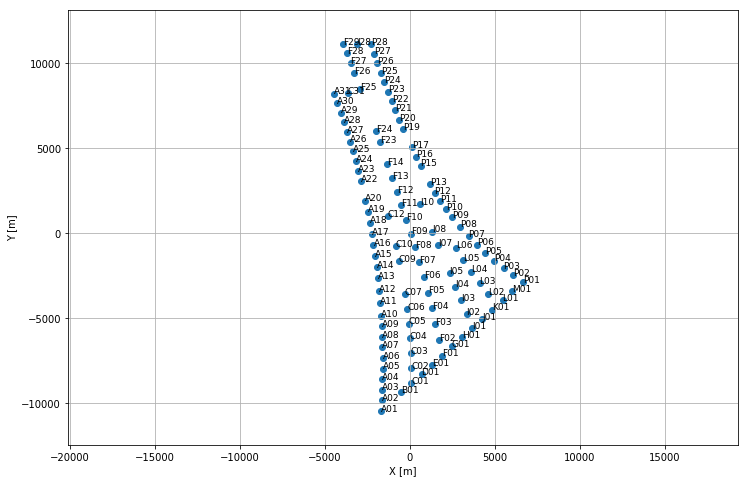

In [376]:
# setup
datefrom = time_stamp(2013,1,1,0,0,0)    # evaluation period
dateto = time_stamp(2015,6,30,23,0,0)    

siteID = 'Anholt'
Hhub = 81.6         # hub-height
Drot = 120          # rotor diameter

# Load manufacturer's power curve 
pwr_curve_file = pd.read_csv('./inputs/Anholt_pwc.csv')
pwr_curve_file['Power'] = pwr_curve_file['Power']/1000 # scale to MW
pwr_curve = interpolate.interp1d(pwr_curve_file['U'].values.flatten(),pwr_curve_file['Power'].values.flatten(), 
                                bounds_error = False, fill_value = 0)
# when converting power to speed use the rev_pwr_curve
###rev_pwr_curve = interpolate.interp1d(pwr_curve_file['power'].values.flatten(),pwr_curve_file['U'].values.flatten())

# Load wind farm layout data
turbines = pd.read_csv("inputs/Anholt_layout.csv")
x_ref, y_ref = centroid(turbines[['X coordinate','Y coordinate']].values) # coordinates of wind farm centroid

plot_wf_layout(turbines['X coordinate']-x_ref, turbines['Y coordinate']-y_ref,labels = turbines['VDC ID'], figsize=(12,8))

## Read data availability flags
This file is provided to the participants so they can compute their bin-averages using the same timestamps of the validation data. Notice that:

* $min\_data\_availability$ sets the minimum availability of original (non-reconstructed) observational data, i.e. for 90%, no more than 10% is reconstructed.

* $scada\_ts$ list the time stamps that will be retained in the analysis

In [377]:
scada_flags = pd.read_csv('./inputs/Anholt_flags.csv', index_col = 'Datetime') 
Ntot = scada_flags.shape[0]     # total number of samples in the scada dataset
min_data_availability = 9
scada_ts = flags_to_ts(scada_flags, min_data_availability) # generate a list of accepted time series

print("Hence, after applying the filter we get %d hourly samples, which is %.2f%% of the original data" % (scada_ts.shape[0],scada_ts.shape[0]*100/Ntot))

Hence, after applying the filter we get 19942 hourly samples, which is 91.21% of the original data


## Wind conditions from mesoscale input data
In the absence of an *undisturbed* met mast, the wind farm centroid is used as reference site to define wind conditions and classify the wind climate in terms of wind direction sectors and stability classes. This site has also been used as the center of the innermost domain in the WRF set-up.

**Fig 1. Distributions at zref for all data (above) and retained for validation (below)**

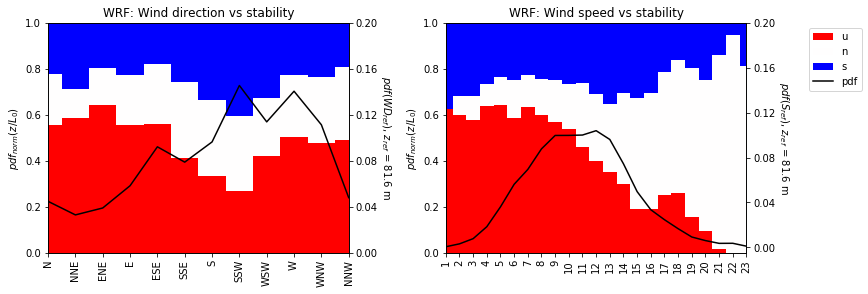

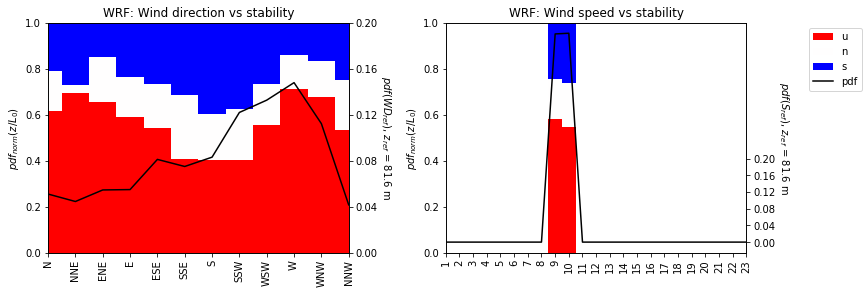

In [378]:
# Define bins to classify wind conditions 
Sbins = np.array([8,10])              # around the maximum of the trust coefficient 
WDbins = np.arange(-15.,360.+15.,30)  # wind direction bins (12 sectors)
WDbins_label = ['N','NNE','ENE','E','ESE','SSE',
                'S','SSW','WSW','W','WNW','NNW']
zLbins = [-0.2,-0.02, 0.02, 0.2]      # 3 stability bins
zLbins_label = ['u','n','s']

# interpolate to reference height
zref = Hhub         # [m]

# Load mesoscale data from the referent site (time-height profiles)
mast = WindConditions('./inputs/Anholt_Control_Lav30km_ref.nc', siteID, datefrom, dateto)

#init the bin averaging class
bin_avrg = BinAvrg(siteID,datefrom, dateto, WDbins, WDbins_label, zLbins, zLbins_label,turbines['VDC ID'],sims["ID"].values)

#filter for wind speed bin
scada_ts = bin_avrg.filter_s(mast, zref, scada_ts, Sbins)

# Compute and plot distributions 
N_WDzL_all,_,_,_,_ = mast.plot_stability(WDbins,WDbins_label,zLbins,zLbins_label,zref)

# after filtering
mast.reduce_to_ts(scada_ts)
N_WDzL_speed,_,_,_,_ = mast.plot_stability(WDbins,WDbins_label,zLbins,zLbins_label,zref)

figcaption = ("**Fig 1. Distributions at zref for all data (above) and retained for validation (below)**")
display(Markdown(figcaption))

In [379]:
Nval = N_WDzL_speed.sum().sum() # total number of samples in the validation dataset
print("Hence, after filtering for the wind speed, stability and direction bins, there are %d hourly samples (%.2f%% of the original data) distributed according to the following validation bins:" % (Nval, Nval*100/Ntot))
N_WDzL_speed

Hence, after filtering for the wind speed, stability and direction bins, there are 3083 hourly samples (14.10% of the original data) distributed according to the following validation bins:


,u,n,s
N,97.0,27.0,33.0
NNE,95.0,5.0,37.0
ENE,110.0,33.0,25.0
E,100.0,29.0,40.0
ESE,135.0,48.0,67.0
SSE,94.0,64.0,73.0
S,103.0,51.0,102.0
SSW,151.0,84.0,141.0
WSW,227.0,73.0,109.0
W,325.0,68.0,63.0


Now we load the mesoscale data interpolated at the turbine positions to generate reference power data that will be used in the definition of array efficiency.

In [380]:
# Load mesoscale data at turbine positions (time-series at hub-height)
f = netCDF4.Dataset('./inputs/Anholt_Control_WindTurbines.nc', 'r')
meso_ts_windspeed = pd.DataFrame(
            (f.variables['U'][:].data**2 + f.variables['V'][:].data**2)**0.5, 
            index = f.variables['Times'][:].data)
meso_ts_windspeed = restrict_to_ts(meso_ts_windspeed, scada_ts)

meso_ts_power = meso_ts_windspeed.transform(pwr_curve) # convert to power

Create mapping of time stamps per wind direction and stability bins

In [381]:
# create mapping, 
ts_bin_map = bin_avrg.create_ts_to_bin_map(mast, zref, scada_ts)
# where ts_bin_map[0][0] provides indices to samples in the N-u bin  

# Compute bin-averaged (and std) quantities,
meso_P, meso_P_std = bin_avrg.compute_mean(meso_ts_power, ts_bin_map)
# where a 3D array is created, e.g. meso_p.loc['ANHA01'].loc['N'].loc['u'] provides the mean power at 
# turbine A01 for North sector in unstable conditions
meso_S, meso_S_std = bin_avrg.compute_mean(meso_ts_windspeed, ts_bin_map)

## Load simulation data

In [382]:
# Loop through the submitted simulation data files and categorize them according to Table 1
sim_ts = []
sim_P = bin_avrg.array_init(('sim', 'wt','wd','zL'))
sim_P_std = bin_avrg.array_init(('sim', 'wt','wd','zL'))
# where sim_P.loc['anh01'].loc['ANHA01'].loc['N'].loc['u'] provides the mean power for anh01 simulation at 
# turbine A01 for North sector in unstable conditions

for isim in range(0,n_sim):
    if isim == n_sim-1:
        print(isim)
        sim_P[isim] = sim_P[ensemble].mean(axis=0)
        sim_P_std[isim] = sim_P_std[ensemble].mean(axis=0)
    else:
        file_name = './outputs/'+ sims["ID"][isim] +'.csv'
        print(file_name)
        ts = p = p_std = None
        if sims["Approach"][isim] == 'ts': 
            ts = pd.read_csv(file_name, index_col = 'time')  # read .csv output files
            p, p_std = bin_avrg.compute_mean(ts, ts_bin_map)   # from time-series to bin-averaged quantities
            # clean up the time series data and apply the scada_ts filter
            ts = restrict_to_ts(ts, scada_ts)
        else:
            p = bin_avrg.read_ba_file(file_name)
        sim_ts.append(ts)
        sim_P[isim] = p
        sim_P_std[isim] = p_std

print('Ensemble generated based on: ' + ', '.join(sims.loc[ensemble]["Label"].tolist()))

./outputs/anh00a.csv
./outputs/anh00b.csv
./outputs/anh00c.csv
./outputs/anh01.csv
./outputs/anh02a.csv
./outputs/anh02b.csv
./outputs/anh05a.csv
./outputs/anh05b.csv
./outputs/anh05c.csv
./outputs/anh05d.csv
./outputs/anh05e.csv
./outputs/anh07a.csv
./outputs/anh07b.csv
./outputs/anh07c.csv
./outputs/anh08a.csv
./outputs/anh08b.csv
./outputs/anh08c.csv


/home/usuario/anaconda2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


./outputs/anh09a.csv
18
Ensemble generated based on: TUD_PARK83_ts_wt, TUD_BasPortéAgel_ts_wt, IFPEN_IsiQian_ba_ref, IFPEN_IsiQian_ts_ref, IFPEN_GaussQian_ts_ref


## Load validation data
To increase the data availability, a machine learning algorithm has been applied to recover data from turbines that are not working in nominal conditions from others that do. Then, the "gap-filled" observational data is loaded and the scada_ts filter applied to syncronize with the simulation data for validation.

In [383]:
try:
    obs_ts = pd.read_csv('./observations/Anholt_obs.csv', index_col = 'time') 
    obs_P, obs_P_std = bin_avrg.compute_mean(obs_ts, ts_bin_map)  
    # clean up the time series data and apply the scada_ts filter
    obs_ts = restrict_to_ts(obs_ts, scada_ts)
    val_data = True
except IOError:
    print ("No validation data available")
    val_data = False

If no validation data is available, do code to code comparison by selecting a reference simulation to compare against:

In [384]:
ref_sim = n_sim-1      # ref_sim = [] when you compare with validation data 

if not ref_sim:
    print ("Your reference series is observations")
    ref_P = obs_P
    ref_P_std = obs_P_std
else: 
    print ("Your reference series is %s " % (sims["Label"][ref_sim]))
    ref_P = sim_P[ref_sim]
    ref_P_std = sim_P_std[ref_sim]

Your reference series is ensemble 


## Compute quantities of interest and metrics
*Array efficiency* for a wind turbine is defined as:

$$ \eta_{i} = \frac{P_i}{P(S_i)} $$

and for the whole wind farm as: 

$$ \eta = \frac{\sum_{i}P_i}{\sum_{i}P(S_i)} $$

where $P_i$ is the power of turbine $i$, observed or simulated, and $P(S_i)$ is the theoretical power from the manufaturer's power curve computed at the background (mesoscale) wind speed $S_i$ at each turbine position.  

Performance is measured in terms of the $BIAS$ and mean absolute error ($MAE$):

$$ BIAS = \eta_{ref} - \eta_{sim} $$ 
$$ MAE = |\eta_{ref} - \eta_{sim}| $$

where the reference data come from either observations or another simulation (typically the ensemble). The metrics are calculated for each turbine and wind farm per bin and integrated for the whole wind distribution. Hence:
* Positive *BIAS* means under-prediction of array efficiency, i.e. the model predicts larger wake losses 
* Negative *BIAS* means over-prediction of array efficiency, i.e. the model predeicts smaller wake losses
* *MAE* avoids the error compensation that takes place in the *BIAS* 

In [385]:
#init the arrays
sim_eta = bin_avrg.array_init(('sim', 'wd','zL'))
bias = bin_avrg.array_init(('sim', 'wd','zL'))
mae = bin_avrg.array_init(('sim', 'wd','zL'))
dif_std = bin_avrg.array_init(('sim', 'wd','zL'))
sim_eta_tot = bin_avrg.array_init(('sim',))
bias_tot = bin_avrg.array_init(('sim',))
mae_tot = bin_avrg.array_init(('sim',))
len_array = np.vectorize(len)
bin_sizes = len_array(ts_bin_map)
sum_bin_sizes = bin_sizes.sum()
meso_P_sum = np.sum(meso_P,axis=0) 

# Wind farm metrics 
ref_eta = 100*np.sum(ref_P,axis=0) / meso_P_sum  # axis=0 are turbines

ref_dif_std = np.mean(ref_P_std - meso_P_std,axis=0)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for isim in range(n_sim):
        sim_eta[isim] = 100*np.sum(sim_P[isim],axis=0) / meso_P_sum 
        bias[isim] = ref_eta - sim_eta[isim]
        mae[isim] = np.absolute(bias[isim])
        if sim_P_std[isim] is not None:
            dif_std[isim] = np.mean(sim_P_std[isim] - ref_P_std,axis=0)
    
        sim_eta_tot[isim] = (sim_eta[isim]*bin_sizes).sum()/sum_bin_sizes
        bias_tot[isim] = (bias[isim]*bin_sizes).sum()/sum_bin_sizes
        mae_tot[isim] = (mae[isim]*bin_sizes).sum()/sum_bin_sizes    

# Wind turbine metrics
sim_eta_wt = bin_avrg.array_init(('sim', 'wt','wd','zL'))
bias_wt = bin_avrg.array_init(('sim', 'wt','wd','zL'))
mae_wt = bin_avrg.array_init(('sim', 'wt','wd','zL'))

ref_eta_wt = 100*ref_P / meso_P 
ref_eta_std_wt = 100*ref_P_std / meso_P 

for isim in range(n_sim):
    sim_eta_wt[isim] = 100*sim_P[isim] / meso_P 
    bias_wt[isim] = ref_eta_wt - sim_eta_wt[isim]
    mae_wt[isim] = np.absolute(bias_wt[isim])
    

## Plot results

In [386]:
# Here you can select which simulations to plot and highlight some of them 
#plotresults = sims.index.tolist()              # all simulations
plotresults = ensemble.copy()                  # simulations participating in the ensemble 
plotresults.append(n_sim-1)                             # and the ensemble itself
plotresults = list(range(4, n_sim)) 
plotresultsname = [sims["Label"][x] for x in plotresults]

#highlight = ['anh01','anh02b','anh05b','anh07a','anh08c','anh09a']          # Highlight results in spagetti plots 
highlight = ['anh05a','anh05b','anh05c','anh05d','anh05e']          # Highlight results in spagetti plots 

### Wind farm metrics

* anh03 and anh04 need to resubmit. The rest show good consistency
* Engineering models are able to predict the array efficiency of the wind farm with a *BIAS* below 1% and *MAE* at 6-7%

,ArrayEff[%],BIAS[%],MAE[%]
Label,,,
TUD_PARK83_ts_wt,85.591171,1.331867,2.317997
TUD_BasPortéAgel_ts_wt,88.420303,-1.497264,1.819229
EMD_PARK2ti002_ts_wt,85.319555,1.603483,2.222675
EMD_PARK2ti003_ts_wt,85.506137,1.416901,2.151373
EMD_PARK2sl1lim01_ts_wt,85.639331,1.283707,2.133760
EMD_PARK2sl1lim02_ts_wt,85.697114,1.225925,2.065188
EMD_PARK2sl2lim02_ts_wt,85.838489,1.084549,2.014780
IFPEN_IsiQian_ba_ref,87.461043,-0.538005,1.380082
IFPEN_IsiQian_ts_ref,87.554678,-0.631640,1.322221


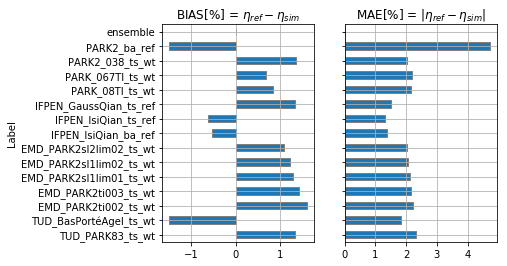

In [387]:
# Compute wind farm metrics
Metrics = pd.DataFrame(np.zeros((n_sim,3)),
                       columns = ['ArrayEff[%]','BIAS[%]','MAE[%]'],
                       index = sims["Label"])
for isim in range(n_sim):
    Metrics.loc[sims["Label"][isim],'ArrayEff[%]'] = sim_eta_tot[isim]
    Metrics.loc[sims["Label"][isim],'BIAS[%]'] = bias_tot[isim]
    Metrics.loc[sims["Label"][isim],'MAE[%]'] = mae_tot[isim]

fig, ax = plt.subplots(nrows=1, ncols=2, sharey='all')
Metrics.iloc[plotresults]['BIAS[%]'].plot.barh(ax = ax[0], rot=0, grid=1, edgecolor = 'grey', title='BIAS[%] = $\eta_{ref}-\eta_{sim}$'); #colormap = 'bwr'
Metrics.iloc[plotresults]['MAE[%]'].plot.barh(ax = ax[1], rot=0, grid=1, edgecolor = 'grey', title='MAE[%] = |$\eta_{ref}-\eta_{sim}$|'); #colormap = 'bwr'

Metrics.iloc[plotresults]

### Bin-averaged metrics
* Bin-averaged *BIAS* show dependency with stability: under-prediction (positive *BIAS*) in stable conditions and over-prediction (negative *BIAS*) in unstable conditions
* Maximum over-prediction of 21% in WNW-u conditions,  18% in N-n and 5% in WSW-s conditions
* Maximum under-prediction of 11% in S-u conditions, 25% in N-n and 30% in N-s conditions
* Wakeblaster showing largest peak errors in North sector 

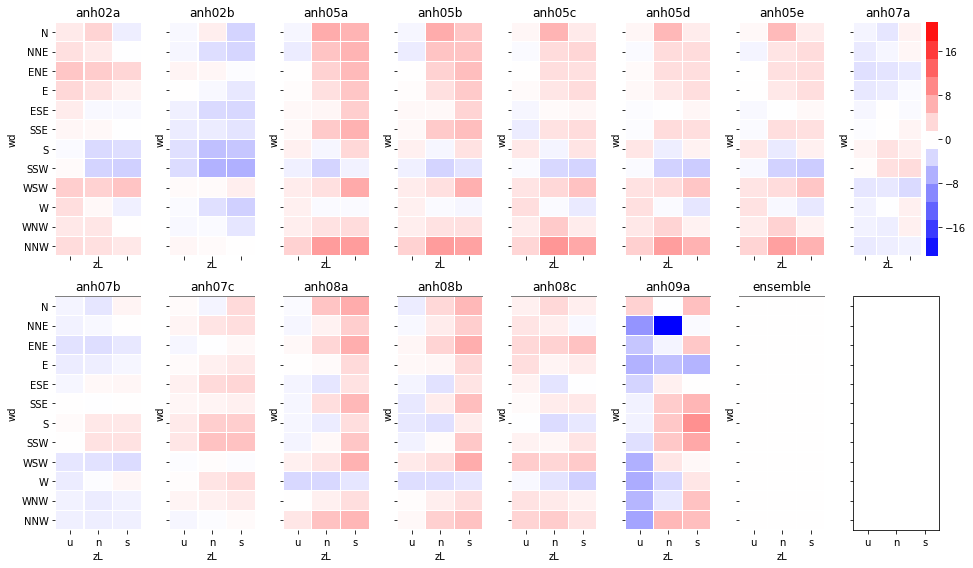

**Heat map of array efficiency BIAS [%]**

In [388]:
figcaption = "**Heat map of array efficiency BIAS [%]**"
title = ""#"_BIAS[%]"
bin_avrg.plot_heatmaps(bias[plotresults], sub_plt_size = (1.7,4),n_plot_cols = 8, 
                       figcaption = figcaption, title=title)

#sim_name, bias.max(axis=1) # Compute maximum per stability

Integrate along wind direction to obtain metrics dependency on stability.
* Positive *BIAS* (under-prediction) in unstable conditions indicate that models are predicting larger wake losses than observations due to wakes decaying slower than they should (under-dissipative conditions). 
* Conversely, negative *BIAS* (neutral and stable conditions) indicate over-dissipative conditions leading to faster wake recovery 
* If input turbulence from mesoscale is over-predicted (more dissipation) this will produce negative *BIAS*. This could explain a non-symetric *BIAS* around neutral     

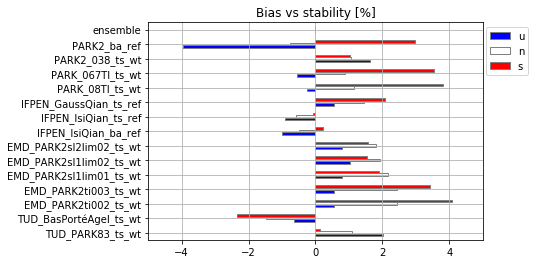

In [395]:
bias_zL = (np.sum(bias[plotresults],axis=1)/len(WDbins)).to_pandas() # bias vs stability [%]
ax = bias_zL.plot.barh(rot=0, grid=1, colormap = 'bwr', edgecolor = 'grey',
                    title='Bias vs stability [%]');
ax.set_yticklabels([sims["Label"][x] for x in plotresults]);
ax.set_ylabel('');
ax.legend(bbox_to_anchor=(1.15, 1)); # try stacked=True in the barh options 
ax.set_xlim([-5,5]); # use this to leave outliers out

#bias_zL # uncomment to show table 

Integrate along stability to obtain metrics dependency on wind direction
* FarmShadow and Wakeblaster differ from the rest in the NE-E (open-sea) sector

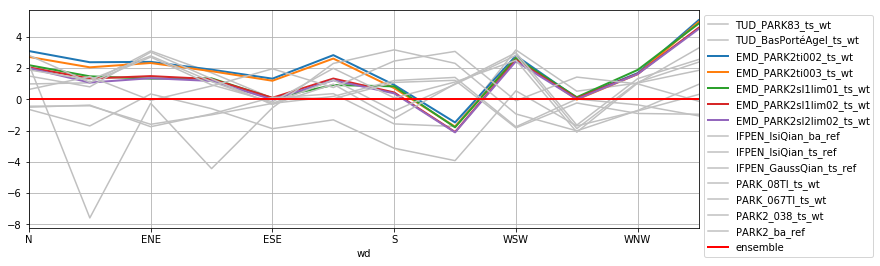

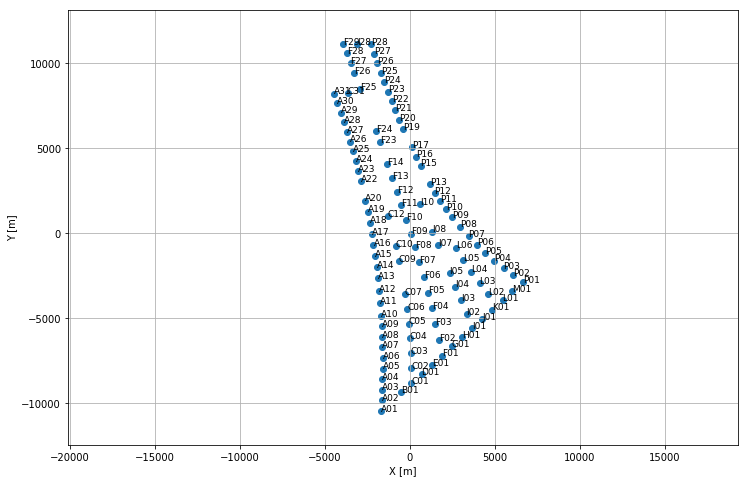

In [390]:
bias_WD = (np.sum(bias[plotresults],axis=2)/len(zLbins)).to_pandas() # bias vs wind direction [%] 

f1, ax = plt.subplots(figsize = (12,4))
for index, row in bias_WD.iterrows():
    rownumber = np.where(bias_WD.index==index)[0][0]
    if index in highlight:
        row.plot(grid=1,linewidth = 2, label = plotresultsname[rownumber])
    elif index == 'ensemble':
        row.plot(grid=1,linewidth = 2, color = 'r',label = plotresultsname[rownumber])
    else:
        row.plot(grid=1, color = 'silver', label = plotresultsname[rownumber])
ax.legend(bbox_to_anchor=(1, 1))

plot_wf_layout(turbines['X coordinate']-x_ref, turbines['Y coordinate']-y_ref,labels = turbines['VDC ID'], figsize=(12,8))
#bias_WD # uncomment to show table

## Wind turbine metrics

Select a simulation and compare with the reference dataset (observations or another simulation).
* $BIAS_{obs}$ in front row of turbines indicative of *BIAS* in mesoscale inflow

In [391]:
sims

,ID,Ensemble,Participant,Model Name,Model Type,Approach,Input,Remarks,Label
0,anh00a,0,CENER,FLORIS,Porté-Agel,ba,"ctrl,ref",Neutral,CENER_PortéAgelNeutral_ba_ref
1,anh00b,0,CENER,FLORIS,Jensen,ba,"ctrl,ref",Neutral,CENER_JensenNeutral_ba_ref
2,anh00c,0,CENER,FLORIS,Multizone,ba,"ctrl,ref",Neutral,CENER_MultizoneNeutral_ba_ref
3,anh01,0,ProPlanEn,WakeBlaster,RANS Eddy-Vis,ts,"ctrl,wt",,ProPlanEn_WakeBlaster_ts_wt
4,anh02a,1,TU-Delft,eWakeLab,PARK83,ts,"ctrl,wt",Dynamic Cw,TUD_PARK83_ts_wt
5,anh02b,1,TU-Delft,eWakeLab,Bastankah&PortéAgel,ts,"ctrl,wt",Dynamic Cw,TUD_BasPortéAgel_ts_wt
6,anh05a,0,EMD,WindPro,PARK2,ts,"ctrl,wt",TI-based lim002,EMD_PARK2ti002_ts_wt
7,anh05b,0,EMD,WindPro,PARK2,ts,"ctrl,wt",TI-based lim003,EMD_PARK2ti003_ts_wt
8,anh05c,0,EMD,WindPro,PARK2,ts,"ctrl,wt",stab slope1lim01,EMD_PARK2sl1lim01_ts_wt
9,anh05d,0,EMD,WindPro,PARK2,ts,"ctrl,wt",stab slope1lim02,EMD_PARK2sl1lim02_ts_wt


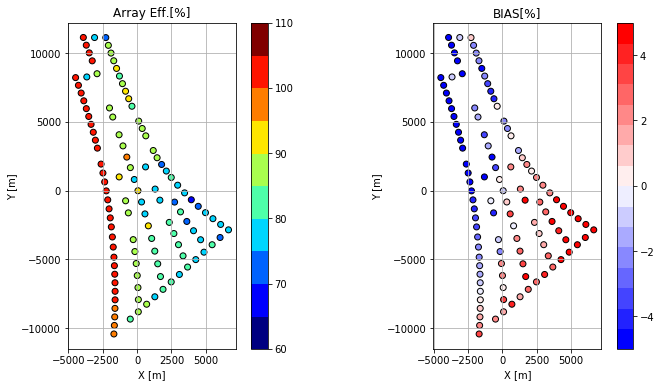

In [392]:
sim = 'anh05a' # select simulation to plot
WDbin = 'W' # select wind direction sector
zLbin = 'n'   # select stability

data = [sim_eta_wt.loc[sim,:,WDbin,zLbin].to_pandas(),
        bias_wt.loc[sim,:,WDbin,zLbin].to_pandas()]
plot_wf_layout(turbines['X coordinate']-x_ref, turbines['Y coordinate']-y_ref,data = data,vmin = [60,-5],vmax = [110,5])

**Plot a transect, for chosen bin and wind turbines list**

Here you can choose a wind direction and stability bin and analyze how the array efficiency changes along a given transect of turbines, with respect to the first turbine in the transect which is used as a reference. Hence, the array efficiency ratio is equal to the net (wake affected) power ratio between the turbine position $P_i$ and the reference $P_0$ times the gross (wake free) power ratio between the reference and the turbine position:

$$ \frac{\eta_i}{\eta_0} = \frac{P_i}{P_0} \frac{P(S_0)}{P(S_i)} $$

where, as described before, $P(S_i)$ is the theoretical power from the power curve computed at the background (mesoscale) wind speed $S_i$. Hence, in horizontally homogeneous conditions the gross power ratio is equal to 1.

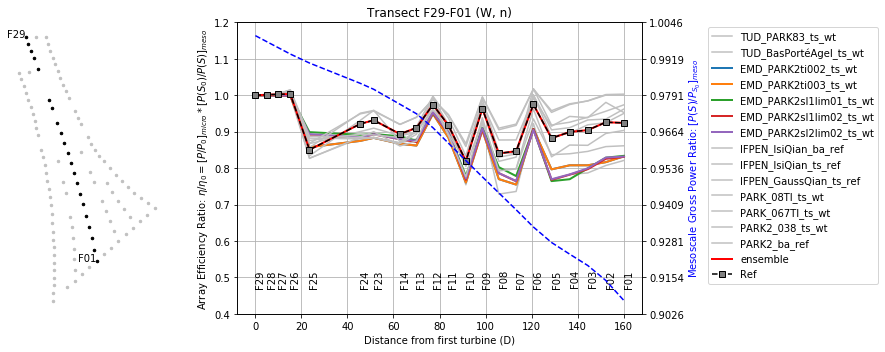

In [393]:
WDbin = 'W'
zLbin = 'n'

# F transect
wt_list = ['F'+"{:0>2d}".format(29-i) for i in range(7)] #from F29 to F23  
wt_list = wt_list + ['F'+"{:0>2d}".format(14-i) for i in range(14)] # from F14 to F01

# A transect
#wt_list = ['A'+"{:0>2d}".format(31-i) for i in range(10)] #from A31 to A22  
#wt_list = wt_list + ['A'+"{:0>2d}".format(20-i) for i in range(20)] # from A20 to A01

# P transect
#wt_list = ['P'+"{:0>2d}".format(28-i) for i in range(10)] #from A31 to A22  
#wt_list = wt_list + ['P'+"{:0>2d}".format(17-i) for i in range(3)] # from F14 to F01
#wt_list = wt_list + ['P'+"{:0>2d}".format(13-i) for i in range(13)] # from F14 to F01

# for list of turbines and wd, 2D plot Value per distance in rotor diameter. 
data =   sim_eta_wt.loc[:,:,WDbin,zLbin].to_pandas()
ref_data = ref_eta_wt.loc[:,WDbin,zLbin].to_pandas()
ref_data_std = ref_eta_std_wt.loc[:,WDbin,zLbin].to_pandas()
meso_data = meso_P.loc[:,WDbin,zLbin].to_pandas()
#meso_data = meso_S.loc[:,WDbin,zLbin].to_pandas()

plot_transect(data.iloc[plotresults],ref_data,meso_data,wt_list,turbines,Drot,
              plotresultsname,WDbin,zLbin,highlight);